In [1]:
# Data packages
import numpy as np
import pandas as pd

# Sci-kit learn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline


# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

1.) (ISLP: Chapter 6, Question 9) In this exercise, we will predict the number of applications
received using the other variables in the College data set.


(a) Split the data set into a training set and a test set. Please use a 50/50 training/test split.
To avoid confusion among partners and facilitate grading, set random_state=37 when
you split the data. Be sure to standardize the data (for models that require it) using the
StandardScaler function. You should scale after splitting your data.

(b) Fit a linear model using least squares on the training set, and report the test error ob-
tained.

(c) Fit a principal components regression (PCR) model on the training set, with M chosen
by cross-validation. 2 Use 10-fold cross-validation (10FCV) on the training set, shuffle
the data randomly for splitting, and set random_state=1. Report the test error ob-
tained, along with the value of M selected by cross-validation, both by minimizing the
appropriate cross-validated error and using the “elbow method.”

(d) Fit a partial least squares (PLS) model on the training set, with M chosen by cross-
validation, using the same cross-validation settings as given in the previous ques-
tion. Report the test error obtained, along with the value of M selected by cross-
validation, both by minimizing the appropriate cross-validated error and using the “el-
bow method.”

(e) Comment on the results obtained. How accurately can we predict the number of college
applications received? Is there much difference among the test errors resulting from
these approaches?

In [2]:
college = pd.read_csv('Data-College.csv')
college['Private'] = college['Private'].replace({'Yes': 1, 'No': 0})

def ols_nator(df):
#a
    X = df.drop(['Apps', 'Unnamed: 0'], axis = 1)
    y = df['Apps']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state = 37)
#b
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

ols_nator(college)

1222954.038253478

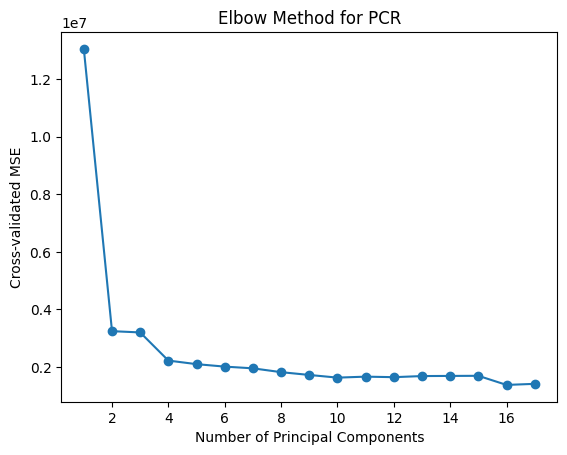

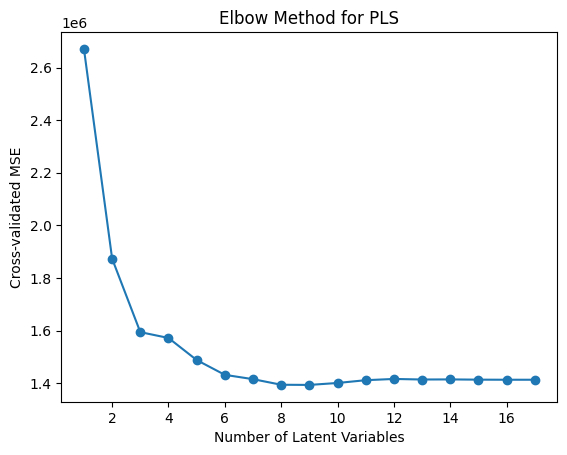

In [3]:
#c
def pcr_nator(df):
    X = df.drop(['Apps', 'Unnamed: 0'], axis=1)
    y = df['Apps']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=37)

    # Perform 10-fold cross-validation for PCR
    cv_errors = []
    pca = PCA()
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    for m in range(1, X_train.shape[1] + 1):
        model_pcr = Pipeline([
            ('scale', StandardScaler()),
            ('pca', pca),
            ('regressor', LinearRegression())
        ])
        pca.n_components = m
        scores = cross_val_score(model_pcr, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
        cv_errors.append(-scores.mean())

    #elbow method
    plt.plot(range(1, X_train.shape[1] + 1), cv_errors, marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cross-validated MSE')
    plt.title('Elbow Method for PCR')
    plt.show()

    optimal_m = np.argmin(cv_errors) + 1

    # Fit PCR model with optimal M
    model_pcr_optimal = Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=optimal_m)),
        ('regressor', LinearRegression())
    ])
    model_pcr_optimal.fit(X_train, y_train)

    # Calculate test error
    y_pred_pcr = model_pcr_optimal.predict(X_test)
    test_error_pcr = mean_squared_error(y_test, y_pred_pcr)

    return test_error_pcr, optimal_m

#d
def pls_nator(df):
    X = df.drop(['Apps', 'Unnamed: 0'], axis=1)
    y = df['Apps']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=37)

    # Perform 10-fold cross-validation for PLS
    cv_errors = []
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    for m in range(1, X_train.shape[1] + 1):
        model_pls = PLSRegression(n_components=m)
        scores = cross_val_score(model_pls, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
        cv_errors.append(-scores.mean())

    # Find M using elbow method
    plt.plot(range(1, X_train.shape[1] + 1), cv_errors, marker='o')
    plt.xlabel('Number of Latent Variables')
    plt.ylabel('Cross-validated MSE')
    plt.title('Elbow Method for PLS')
    plt.show()

    optimal_m = np.argmin(cv_errors) + 1

    # Fit PLS model with optimal M
    model_pls_optimal = PLSRegression(n_components=optimal_m)


pcr_nator(college)
pls_nator(college)

(a) Sketch the tree corresponding to the partition of the predictor space illustrated in the
left-hand panel of the figure. The numbers inside the boxes indicate the mean of Y
within each region.

- see attached PDF

(b) Create a diagram similar to the left-hand panel of the figure, using the tree illustrated in
the right-hand panel of the same figure. You should divide up the predictor space into
the correct regions, and indicate the mean for each region.

- See attached PDF

3.) (ISLP: Chapter 8, Question 9) This question involves the OJ data set which is available on
Canvas

(a) Create a training set and a test set. Please use a 70/30 training/test split and set
random_state=3 when you split the data.

(b) Fit a full, unpruned tree to the training data, with Purchase as the response and the
other variables as predictors. When calling the DecisionTreeClassifier() function, please set random_state=2 . What is the training error rate?

In [11]:
oj = pd.read_csv('Data-OJ.csv')
oj['Store7'] = oj['Store7'].replace({'Yes': 1, 'No': 0})

#b
def unpruned_nator(df):
    X = df.drop(['Purchase'], axis=1)
    y = df['Purchase']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
    
        # No stopping criterion
    full_model = DecisionTreeClassifier(
        random_state=12,
        criterion='gini')
    full_model.fit(X_train, y_train)

    print(f'Training Accuracy: {full_model.score(X_train, y_train)}')
    print(f'Test Accuracy: {full_model.score(X_test, y_test)}')
    return full_model

unpruned_nator(oj)

Training Accuracy: 0.9933244325767691
Test Accuracy: 0.7538940809968847


DecisionTreeClassifier(random_state=12)